In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../lib")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import temporal_encoder_common
from temporal_encoder_common import Filters
import nonneg_common
import lif_utils
import nengo
import dlop_ldn_function_bases as bases
import basis_delay_analysis_common

In [4]:
def mk_cosine_bartlett_basis_with_spread(q,
                                         N,
                                         T=1.0,
                                         dt=1e-3,
                                         phi_max=2.0,
                                         decay_min=1.5,
                                         decay_max=1.5,
                                         rng=np.random):
    phis = np.linspace(0, phi_max, q) * 2.0 * np.pi
    phases = rng.uniform(0, np.pi, q)
    t1 = rng.uniform(decay_min, decay_max, q) * T
    ts = np.arange(N) * dt
    return (
        np.cos(ts[None, :] * phis[:, None] / t1[:, None] + phases[:, None]) *
        (1.0 - ts[None, :] / t1[:, None]) * (ts[None, :] <= t1[:, None]))


In [23]:
def mk_gaussian_basis(q, N, T=1.0, dt=1e-3):
    ts = np.arange(N) * dt
    mus = np.random.uniform(-0.1, T, q)
    sigmas = np.power(10.0, np.random.uniform(-1.0, -0.5, q))
    res = np.exp(-np.square(ts[None, :] - mus[:, None]) /
                  np.square(sigmas[:, None]))
    return res / np.sum(res, axis=1)[:, None] / dt

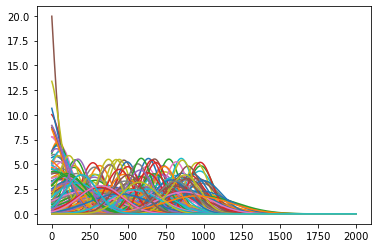

In [24]:
fig, ax = plt.subplots()
H = mk_gaussian_basis(200, 2000)
ax.plot(H.T);

(1e-06, 1)

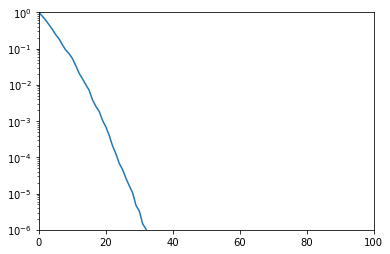

In [25]:
U, S, V = np.linalg.svd(H)
fig, ax = plt.subplots()
ax.plot(S / np.max(S))
ax.set_yscale('log')
ax.set_xlim(0, 100)
ax.set_ylim(1e-6, 1)

In [26]:
n_neurons = 200
n_temporal_dimensions = 200

gains, biases, Es = nonneg_common.mk_ensemble(n_neurons, d=n_temporal_dimensions)
G = lif_utils.lif_rate
#TEs = Es
TEs = np.diag(np.random.choice([-1, 1], n_temporal_dimensions))

#A, B = bases.mk_ldn_lti(n_temporal_dimensions)
#A = np.zeros((1, 1))
#B = np.ones((1,))


T, dt = 10.0, 1e-3
ts = np.arange(0, T, dt)
#Ms = temporal_encoder_common.cached_lti_impulse_response(A, B, ts)
#Ms = mk_cosine_bartlett_basis_with_spread(n_temporal_dimensions, len(ts)).T
Ms = mk_gaussian_basis(n_temporal_dimensions, len(ts)).T
#print(Ms.shape)
#_, Ms = basis_delay_analysis_common.mk_impulse_response(
#            basis="mod_fourier",
#            window="erasure",
#            q=n_temporal_dimensions,
            #T=T,
            #dt=dt,
            #use_euler=True,
            #rescale_ldn=False)


flt_mu = 100e-3
flt_sigma = 0e-3
flt_min = 1e-3

def mk_flts(shape, digits=1):
    taus = np.clip(np.random.normal(flt_mu, flt_sigma, shape), flt_min, None)
    taus = np.exp(np.round(np.log(taus), digits))
    return taus

# Generate a set of filters discrete filters
np.random.seed(3819)
flts_in = np.geomspace(1e-3, 400e-3, 11)
flts_rec = mk_flts((n_neurons, n_neurons))

# Collect unique filters
flts = np.unique(np.concatenate((np.unique(flts_in), np.unique(flts_rec))))
i_mu = np.argmin(np.abs(flts - flt_mu))

# Map from the filters onto indices into the unique filter list
flts_map = {value: idx for idx, value in enumerate(flts)}
flts_in_map = np.array([flts_map[flt] for flt in flts_in])
flts_rec_map = np.array([flts_map[flt] for flt in flts_rec.flat]).reshape(n_neurons, n_neurons)

In [27]:
np.random.seed(48181)
W_in, W_rec, errs = temporal_encoder_common.solve_for_recurrent_population_weights_heterogeneous_filters(G,
                                           gains,
                                           biases,
                                           None, None,
                                           TEs,
                                           [Filters.lowpass(tau) for tau in flts],
                                           flts_in_map,
                                           flts_rec_map,
                                           Ms=Ms,
                                           N_smpls=100,
                                           reg=1e-2,
                                           xs_sigma=3.0,
                                           biased=False,)

100%|██████████| 200/200 [00:02<00:00, 84.45it/s]


In [28]:
errs

array([0.01817066, 0.00204258, 0.00253225, 0.01055698, 0.00648171,
       0.00220452, 0.00226434, 0.00258417, 0.0016845 , 0.00371663,
       0.00268874, 0.0028591 , 0.00357056, 0.00246013, 0.01785413,
       0.00221354, 0.00586526, 0.00314721, 0.00874402, 0.00233012,
       0.02035191, 0.00381603, 0.00250365, 0.01862099, 0.00569012,
       0.00236068, 0.00268105, 0.00577665, 0.0181637 , 0.00254384,
       0.0214498 , 0.00256437, 0.00195054, 0.00254839, 0.00153432,
       0.0115696 , 0.00387996, 0.00367327, 0.00158427, 0.00663416,
       0.00147525, 0.01982711, 0.00312922, 0.0044271 , 0.00746463,
       0.00152248, 0.0044539 , 0.00150535, 0.00247367, 0.00343246,
       0.002202  , 0.00398115, 0.01662782, 0.01580026, 0.00126297,
       0.00194959, 0.00362307, 0.00893168, 0.00252099, 0.00354644,
       0.00949127, 0.00910876, 0.02260944, 0.007193  , 0.00228113,
       0.00263827, 0.00199898, 0.01158597, 0.00154459, 0.00505142,
       0.00563973, 0.01075538, 0.0058373 , 0.00148467, 0.00426

In [29]:
from nengo.utils.ensemble import response_curves, tuning_curves

def LP(*args):
    return nengo.LinearFilter(*Filters.lowpass_laplace(*args), analog=True)

np.random.seed(48189)

with nengo.Network() as model:
    nd_in = nengo.Node(nengo.processes.WhiteSignal(period=10.0, high=2.0, y0=0.0, rms=0.5))
    #nd_in = nengo.Node(lambda t: -10.0 * np.logical_and(t > 0.1, t < 0.2))
    ens_x = nengo.Ensemble(
        n_neurons=n_neurons,
        dimensions=n_temporal_dimensions,
        bias=biases,
        gain=gains,
        encoders=TEs,)

    for i, flt_idx in enumerate(flts_in_map):
        tau = flts[flt_idx]
        nengo.Connection(
            nd_in, ens_x.neurons,
            transform=W_in[:, i:(i+1)],
            synapse=tau)

    for i, tau in enumerate(flts):
        mask_rec = flts_rec_map == i
        if np.any(mask_rec):
            nengo.Connection(
                ens_x.neurons, ens_x.neurons,
                transform=(W_rec * mask_rec),
                synapse=LP(tau))

    p_in = nengo.Probe(nd_in, synapse=None)
    p_out = nengo.Probe(ens_x.neurons, synapse=None)

with nengo.Simulator(model) as sim:
    sim.run(10.0)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

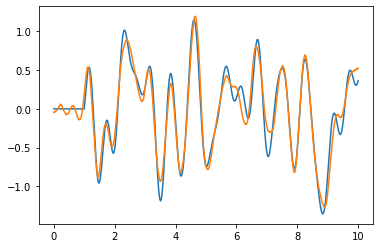

In [40]:
ts = sim.trange()
As = sim.data[p_out]
As_flt = nengo.Lowpass(100e-3).filtfilt(As)
xs = sim.data[p_in]
xs_delay = np.concatenate((np.zeros(1000), xs[:, 0]))[:xs.shape[0]]

fig, ax = plt.subplots()
D = np.linalg.lstsq(As_flt, xs_delay, rcond=1e-2)[0]

ax.plot(ts, xs_delay)
ax.plot(ts, As_flt @ D)

(0.0, 3000.0)

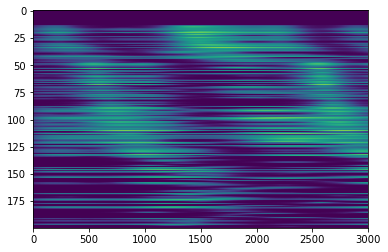

In [41]:
fig, ax = plt.subplots()
sort_idcs = np.argsort(np.argmax(As_flt[0:1000], axis=0))
ax.imshow(As_flt[:, sort_idcs].T, vmin=0.0, vmax=100.0)
ax.set_aspect('auto')
ax.set_xlim(0, 3000)

213.33139643725985
162.83269855634902
0.40884095556987166
150.395881779576
141.38699824109239
46.87763275143273
101.53397358800908
206.85669022708615
173.54919629697673
81.3200980640252
150.37703176424483
128.89273769091537
62.495755325906956
187.33411471252728
158.47375330239802
179.12012455857948
17.314006218588624
38.763469448308044
148.62142259723268
40.02873916613049
192.64261288308307
204.47687836338278
0.36942777544065736
201.94648136535756
130.73102385143966
209.27137371618218
129.19384013183014
0.4185642976276442
171.48798271210072
161.52255541578444
164.27874942454667
122.02729129695543
180.3050048542421
70.68025432531458
56.54133871131665
64.07935861723638
181.91109143003553
193.9382967886692
152.25978294141092
214.96188517916127
199.0341178833719
86.63398088101279
105.41188308528322
33.14969851129344
188.90135426445084
69.24841963810889
140.3128699361801
146.2481013022995
58.34923670381057
75.55429454917224
45.803456969872165
189.0107549013969
34.67397269515565
137.17570596

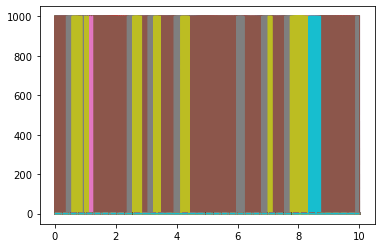

In [277]:
fig, ax = plt.subplots()
ax.plot(ts, sim.data[p_in], 'k--')
ax.plot(ts, sim.data[p_out]);

ax.set_prop_cycle(None)
for i in range(n_temporal_dimensions):
    tar = np.convolve(sim.data[p_in][:, 0], Ms[:, i], 'full')[:len(ts)] * dt
    tar_flt = nengo.Lowpass(100e-3).filt(tar, dt=dt)
    ax.plot(ts, tar_flt, '--')
    print(np.sqrt(np.mean(np.square(tar_flt - sim.data[p_out][:, i]))))

#ax.set_xlim(1, 4)

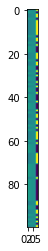

In [91]:
fig, ax = plt.subplots()
ax.imshow(W_in)

0.04012791345584976
0.08837424297201685
0.07101969810270052


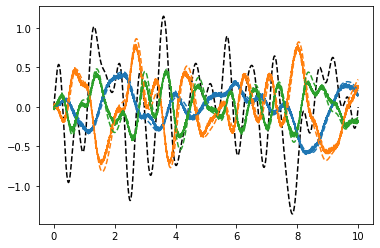

In [504]:
fig, ax = plt.subplots()
ax.plot(ts, sim.data[p_in], 'k--')
ax.plot(ts, sim.data[p_out]);

ax.set_prop_cycle(None)
for i in range(n_temporal_dimensions):
    tar = np.convolve(sim.data[p_in][:, 0], Ms[:, i], 'full')[:len(ts)] * dt
    tar_flt = nengo.Lowpass(100e-3).filt(tar, dt=dt)
    ax.plot(ts, tar_flt, '--')
    print(np.sqrt(np.mean(np.square(tar_flt - sim.data[p_out][:, i]))))

#ax.set_xlim(1, 4)

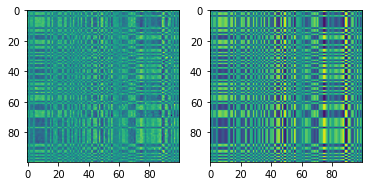

In [495]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(W_rec)
axs[1].imshow(W_rec_ref)

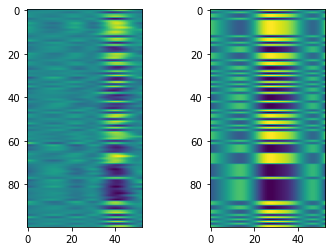

In [496]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(W_in)
axs[1].imshow(W_in_ref)

In [528]:
_, S, _ = np.linalg.svd(W_rec)
np.sum(S / np.max(S)), np.sum(S / np.max(S) > 1e-2)

(8.435197143407649, 84)

In [526]:
_, S, _ = np.linalg.svd(W_rec_ref)
np.sum(S / np.max(S)), np.sum(S / np.max(S) > 1e-2)

(1.8060774591038777, 3)

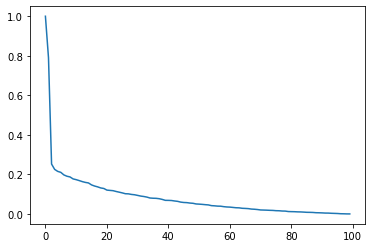

In [529]:
fig, ax = plt.subplots()
ax.plot(S / np.max(S))